In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from collections import Counter
from torchtext.vocab import vocab
from torchtext.vocab import build_vocab_from_iterator
import nltk

In [2]:
BASE_DIR = 'archive (8)'
WORKING_DIR = 'model1'

Feature Extraction


In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=True)
model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-1])
model = model.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

directory = os.path.join(BASE_DIR, 'Images')

features = {}
for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    image = Image.open(img_path).convert('RGB') 
    
    image = preprocess(image).unsqueeze(0) 
    image = image.to(device)
    
    with torch.no_grad():
        feature = model(image)
    
    feature_np = feature.cpu().numpy()
    
    image_id = img_name.split('.')[0]
    features[image_id] = feature_np



c:\Users\chait\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\chait\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/31783 [00:00<?, ?it/s]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(pretrained=True)
model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-1])
model = model.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'sboreddy_aghanta_indushre_features_LSTM.pkl'), 'wb'))

In [8]:
with open(os.path.join(WORKING_DIR, 'sboreddy_aghanta_indushre_features_LSTM.pkl'), 'rb') as f:
    features = pickle.load(f)

In [9]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r', encoding='utf-8') as f:
    next(f) 
    captions_doc = f.read()


In [10]:
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/158916 [00:00<?, ?it/s]

In [11]:
len(mapping)

31783

In [12]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
C:\Users\chait\AppData\Local\Temp\ipykernel_28732\782023681.py:7: SyntaxWarning: invalid escape sequence '\s'
  caption = caption.replace('\s+', ' ')


In [13]:
# before preprocess of text
mapping['1000268201']

[' A child in a pink dress is climbing up a set of stairs in an entry way .',
 ' A little girl in a pink dress going into a wooden cabin .',
 ' A little girl climbing the stairs to her playhouse .',
 ' A little girl climbing into a wooden playhouse ',
 ' A girl going into a wooden building .']

In [14]:
clean(mapping)

In [15]:
mapping['1000268201']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq girl going into wooden building endseq']

In [16]:
from collections import Counter
from torchtext.vocab import vocab
from torchtext.vocab import build_vocab_from_iterator
import nltk
nltk.download('punkt')


def tokenize(text):
    return nltk.word_tokenize(text.lower())


def yield_tokens(all_captions):
    for caption in all_captions:
        yield tokenize(caption)


all_captions = [caption for key in mapping for caption in mapping[key]]

counter = Counter()
for caption in all_captions:
    counter.update(tokenize(caption))

my_vocab = vocab(counter)

default_tokens = {'<unk>': 0, '<pad>': 1, '<bos>': 2, '<eos>': 3}
for token, index in default_tokens.items():
    my_vocab.insert_token(token, index)

my_vocab.set_default_index(my_vocab['<unk>'])
vocab_size = len(my_vocab)

print(f"Vocabulary size: {vocab_size}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chait\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Vocabulary size: 20268


In [17]:
len(all_captions)

158915

In [18]:
vocab_size

20268

In [19]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

75

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

class CaptionDataset(Dataset):
    def __init__(self, data_keys, mapping, features, tokenizer, max_length, vocab):
        self.data_keys = data_keys
        self.mapping = mapping
        self.features = features
        self.tokenizer = tokenizer  
        self.max_length = max_length
        self.vocab = vocab  

    def __len__(self):
        return len(self.data_keys)

    def __getitem__(self, idx):
        key = self.data_keys[idx]
        image_feature = torch.tensor(self.features[key][0], dtype=torch.float)
        captions = self.mapping[key]
        caption = captions[torch.randint(len(captions), (1,)).item()]
        tokens = self.tokenizer(caption)
        numericalized_caption = [self.vocab[word] if word in self.vocab else self.vocab['<unk>'] for word in tokens]
        numericalized_caption = torch.tensor(numericalized_caption, dtype=torch.long)

        return image_feature, numericalized_caption

def collate_fn(data):
    image_features, captions = zip(*data)
    image_features = torch.stack(image_features, 0)
    captions = pad_sequence(captions, batch_first=True, padding_value=0)  

    return image_features, captions

In [22]:
import torch.nn as nn
import torch.nn.functional as F
class CaptioningModel(nn.Module):
    def __init__(self, vocab_size, max_length, feature_dim=4096, embedding_dim=256, hidden_dim=256): 
        super(CaptioningModel, self).__init__()  
        self.dropout1 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(feature_dim, embedding_dim)  
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.dropout2 = nn.Dropout(0.4)
        self.lstm = nn.LSTM(2 * embedding_dim, hidden_dim, batch_first=True)

        self.fc2 = nn.Linear(hidden_dim, embedding_dim)  
        self.outputs = nn.Linear(embedding_dim, vocab_size)

    def forward(self, img_features, captions):
        img_features = self.dropout1(img_features)
        img_features = F.relu(self.fc1(img_features)) 

        img_features_repeated = img_features.unsqueeze(1).repeat(1, captions.size(1), 1)  

        captions = self.embedding(captions) 
        captions = self.dropout2(captions)

        combined_inputs = torch.cat((img_features_repeated, captions), dim=2)  
        lstm_out, _ = self.lstm(combined_inputs)  
        decoded = F.relu(self.fc2(lstm_out))  
        outputs = self.outputs(decoded)  

        return outputs

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
vocab_size = vocab_size  
max_length = max_length  

model = CaptioningModel(vocab_size, max_length)
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.to(device)

CaptioningModel(
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (embedding): Embedding(20268, 256, padding_idx=0)
  (dropout2): Dropout(p=0.4, inplace=False)
  (lstm): LSTM(512, 256, batch_first=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (outputs): Linear(in_features=256, out_features=20268, bias=True)
)

In [24]:

train_dataset = CaptionDataset(train, mapping, features, tokenize, max_length, my_vocab)
test_dataset = CaptionDataset(test, mapping, features, tokenize, max_length, my_vocab)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [66]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn


epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_accuracies = []
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for img_features, captions in train_loader:
        img_features, captions = img_features.to(device), captions.to(device)

        optimizer.zero_grad()

        outputs = model(img_features, captions[:, :-1])
        # print("Output shape before flattening:", outputs.shape)
        # print("Target shape before flattening:", captions[:, 1:].shape)

        
        outputs_flat = outputs.view(-1, outputs.shape[-1])
        #outputs_flat = outputs.reshape(-1, vocab_size)
        #targets_flat = captions[:, 1:].reshape(-1)
        targets_flat = captions[:, 1:].contiguous().view(-1)
        loss = criterion(outputs_flat, targets_flat)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted_indices = torch.max(outputs_flat, 1)
        correct_predictions += (predicted_indices == targets_flat).sum().item()
        total_predictions += targets_flat.size(0)

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)
    accuracy = 100 * correct_predictions / total_predictions
    train_accuracies.append(accuracy)

    print(f'Epoch {epoch+1}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%')


C:\Users\chait\AppData\Local\Temp\ipykernel_28732\2801562604.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_feature = torch.tensor(self.features[key][0], dtype=torch.float)


Epoch 1, Loss: 1.2279, Accuracy: 76.05%
Epoch 2, Loss: 1.2259, Accuracy: 76.23%
Epoch 3, Loss: 1.2305, Accuracy: 75.97%
Epoch 4, Loss: 1.2161, Accuracy: 76.10%
Epoch 5, Loss: 1.2298, Accuracy: 75.97%
Epoch 6, Loss: 1.2149, Accuracy: 76.10%
Epoch 7, Loss: 1.2026, Accuracy: 76.44%
Epoch 8, Loss: 1.2047, Accuracy: 76.41%
Epoch 9, Loss: 1.2214, Accuracy: 76.11%
Epoch 10, Loss: 1.2185, Accuracy: 76.01%
Epoch 11, Loss: 1.2281, Accuracy: 75.63%
Epoch 12, Loss: 1.2178, Accuracy: 75.90%
Epoch 13, Loss: 1.1975, Accuracy: 76.50%
Epoch 14, Loss: 1.1982, Accuracy: 76.47%
Epoch 15, Loss: 1.2100, Accuracy: 76.07%
Epoch 16, Loss: 1.1993, Accuracy: 76.34%
Epoch 17, Loss: 1.1798, Accuracy: 76.84%
Epoch 18, Loss: 1.1880, Accuracy: 76.67%
Epoch 19, Loss: 1.1791, Accuracy: 76.84%
Epoch 20, Loss: 1.1999, Accuracy: 76.06%
Epoch 21, Loss: 1.1950, Accuracy: 76.37%
Epoch 22, Loss: 1.1989, Accuracy: 76.22%
Epoch 23, Loss: 1.1928, Accuracy: 76.22%
Epoch 24, Loss: 1.1988, Accuracy: 76.39%
Epoch 25, Loss: 1.1736, A

In [67]:
from torch.utils.data import DataLoader
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  

model.eval()

total_loss = 0.0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():  
    for img_features, captions in test_loader:  
        img_features, captions = img_features.to(device), captions.to(device)
        
        outputs = model(img_features, captions[:, :-1])
        outputs_flat = outputs.reshape(-1, vocab_size)  
        targets_flat = captions[:, 1:].reshape(-1)  

        loss = criterion(outputs_flat, targets_flat)
        total_loss += loss.item()

        _, predicted_indices = torch.max(outputs_flat, 1)  
        correct_predictions += (predicted_indices == targets_flat).sum().item()
        total_predictions += targets_flat.size(0)

average_loss_t = total_loss / len(test_loader)
accuracy_t = 100 * correct_predictions / total_predictions

print(f'Test Loss: {average_loss_t:.4f}, Test Accuracy: {accuracy_t:.2f}%')

C:\Users\chait\AppData\Local\Temp\ipykernel_28732\2801562604.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_feature = torch.tensor(self.features[key][0], dtype=torch.float)


Test Loss: 1.4486, Test Accuracy: 75.16%


C:\Users\chait\AppData\Local\Temp\ipykernel_28732\1470878739.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(epochs, test_accuracy_list, 'b-', label='Test Accuracy', linestyle='dashed')


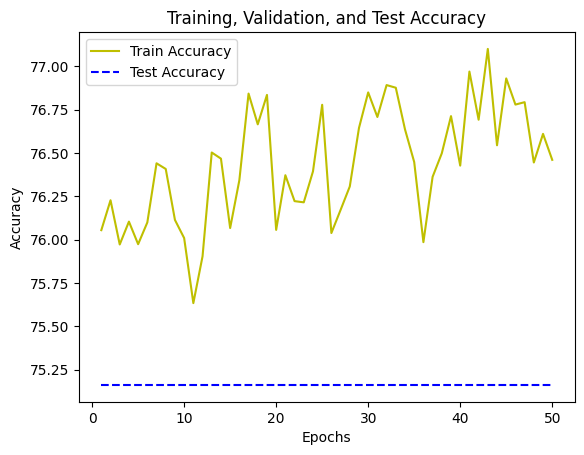

C:\Users\chait\AppData\Local\Temp\ipykernel_28732\1470878739.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(epochs, test_loss_list, 'g-', label='Test Loss', linestyle='dashed')


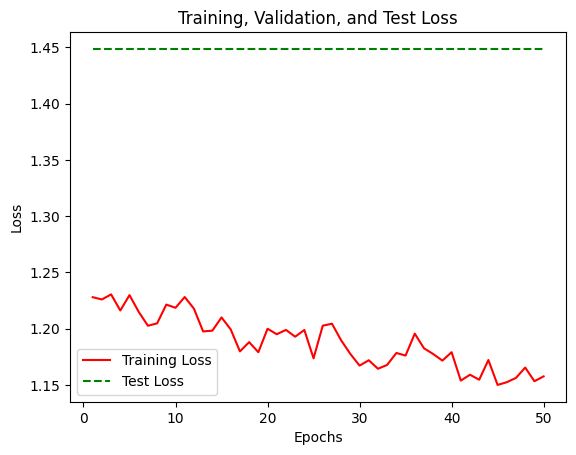

In [68]:
import matplotlib.pyplot as plt

num_epochs = epochs 

epochs = range(1, num_epochs + 1)
test_accuracy_list = [accuracy_t] * num_epochs
test_loss_list = [average_loss_t] * num_epochs

plt.figure()
plt.plot(epochs, train_accuracies, 'y-', label='Train Accuracy')
plt.plot(epochs, test_accuracy_list, 'b-', label='Test Accuracy', linestyle='dashed')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()

plt.plot(epochs, train_losses, 'r-', label='Training Loss')
plt.plot(epochs, test_loss_list, 'g-', label='Test Loss', linestyle='dashed')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [79]:
torch.save(model.state_dict(), 'sboreddy_aghanta_indushree_VGG16_LSTM.pth')

In [21]:
model.load_state_dict(torch.load('VGG16_LSTM_75.pth'))

<All keys matched successfully>

In [69]:
for key in features.keys():
    features[key] = torch.tensor(features[key]).float()  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for key in features.keys():
    features[key] = features[key].to(device)

C:\Users\chait\AppData\Local\Temp\ipykernel_28732\2200572370.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features[key] = torch.tensor(features[key]).float()


In [70]:
def idx_to_word(index, my_vocab):
    return my_vocab.get_itos()[index]

In [71]:
import matplotlib.pyplot as plt
def predict_caption(model, image_feature, vocab, max_length, device):
    model = model.to(device)
    model.eval()

    in_text = [vocab['startseq']]
    result = []


    for _ in range(max_length):
        sequence = torch.tensor([in_text], dtype=torch.long).to(device)

        with torch.no_grad():
            output = model(image_feature, sequence) 
            yhat = output[:, -1, :]
            yhat = torch.argmax(yhat, dim=-1)

        word = idx_to_word(yhat.item(), vocab)
        if word == '<eos>' or word == 'endseq':
            break
        result.append(word)
        in_text.append(yhat.item())

    return ' '.join(result)

---------------------Actual---------------------
startseq two men volleyball players in light blue uniforms spiking the ball over the net during men 's volleyball game endseq
startseq the black team is about to lose the championship against the blue team endseq
startseq two men volleyball player go for the ball endseq
startseq why are grown men playing volleyball endseq
startseq men playing volleyball indoors endseq
--------------------Predicted--------------------
group of young girls are playing volleyball


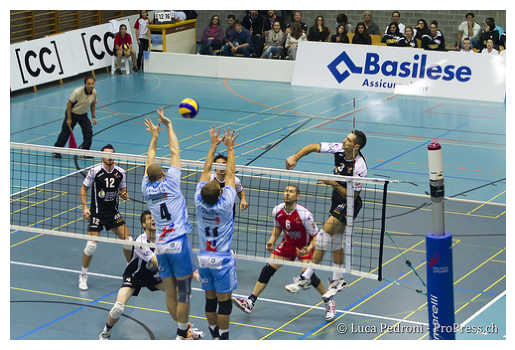

In [72]:
def generate_caption(image_name, model, features, mapping, vocab, max_length, device):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    image_feature = features[image_id].to(device) 

    if image_feature is not None:
        y_pred = predict_caption(model, image_feature, vocab, max_length, device) 
        print('--------------------Predicted--------------------')
        print(y_pred)
    else:
        print("Image features not found.")

    plt.imshow(image)
    plt.axis('off')
    plt.show()


generate_caption("8188882833.jpg", model, features, mapping, my_vocab, max_length, device)

---------------------Actual---------------------
startseq children doing art projects on table with bicycle and sundry equipment in the background ." endseq
startseq two girls in green shirts and two in white shirts are painting pictures ." endseq
startseq four female children gather around brown table to paint endseq
startseq several little girls are at table painting endseq
startseq group of little kids paintings endseq
--------------------Predicted--------------------
woman in blue shirt is selling food


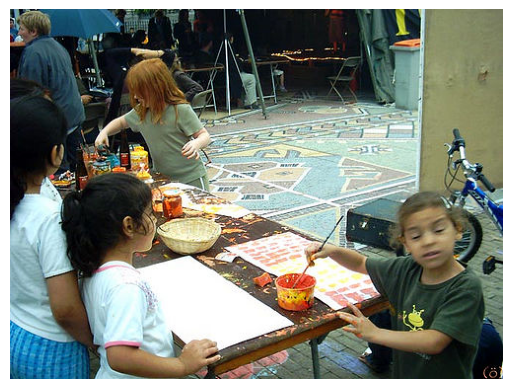

In [73]:
generate_caption("438106.jpg", model, features, mapping, my_vocab, max_length, device)

---------------------Actual---------------------
startseq several african americans are outside in front of store with four children two women and one man and the interest of three of the subjects are capture by something off-frame ." endseq
startseq four children are sitting on the ground next to tree that is white around the trunk endseq
startseq several adults stand and four children sit in front of small store endseq
startseq four little black boys and three black adults are outside of store endseq
startseq family is sitting outside store endseq
--------------------Predicted--------------------
group of children are sitting on the floor


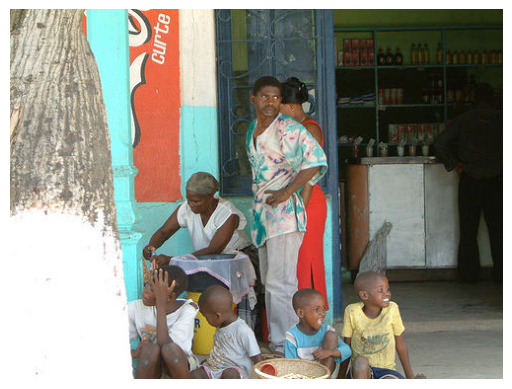

In [74]:
generate_caption("3012229.jpg", model, features, mapping, my_vocab, max_length, device)

---------------------Actual---------------------
startseq little girl with long brown hair and hat made out of newspaper is opening gift while other people watch endseq
startseq girl wearing paper hat opens present wrapped in pink wrapping paper while others look on endseq
startseq young girl with bow on her head opening present with people standing around her endseq
startseq yong girl opens present wrapped in pink wrapping paper endseq
startseq girl in newspaper hat with bow is unwrapping an item endseq
--------------------Predicted--------------------
woman in pink shirt is holding baby


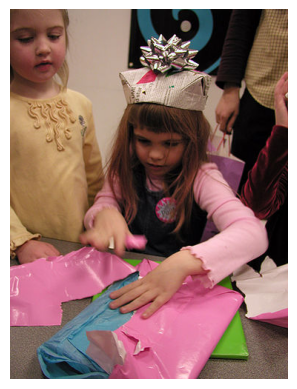

In [75]:
generate_caption("5060753.jpg", model, features, mapping, my_vocab, max_length, device)

---------------------Actual---------------------
startseq blond girl and bald man with his arms crossed are standing inside looking at each other endseq
startseq worker is being scolded by her boss in stern lecture endseq
startseq manager talks to an employee about job performance endseq
startseq hot blond girl getting criticized by her boss ." endseq
startseq sonic employees talking about work endseq
--------------------Predicted--------------------
man in black shirt is looking at something in his hand


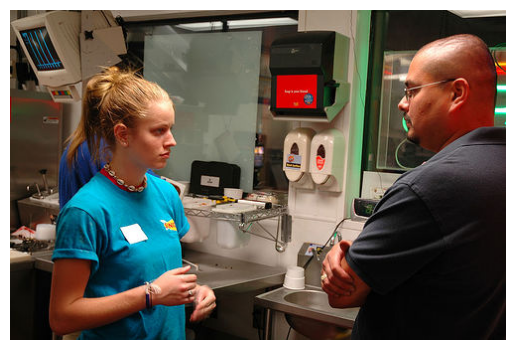

In [76]:
generate_caption("8063007.jpg", model, features, mapping, my_vocab, max_length, device)

---------------------Actual---------------------
startseq girl in floral bathing suit jumping on the beach in front of the waves endseq
startseq little girl in flower print bathing suit jumping into the ocean ." endseq
startseq girl in swimsuit is jumping high near water ." endseq
startseq young girl is jumping in the air at the beach endseq
startseq girl jumping into the ocean endseq
--------------------Predicted--------------------
young boy in red shorts is running on the beach


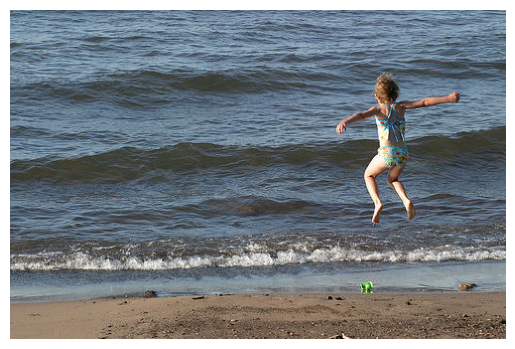

In [77]:
generate_caption("10957138.jpg", model, features, mapping, my_vocab, max_length, device)

---------------------Actual---------------------
startseq bunch of construction workers work on street while one worker walks toward the camera endseq
startseq man wearing yellow hard hat and orange shirt with yellow strips walking endseq
startseq construction worker walks down the street while others are at work ." endseq
startseq man in an orange shirt and yellow hard hat walks on road endseq
startseq workers are repairing road under bridge endseq
--------------------Predicted--------------------
man in blue shirt and jeans is walking down the street


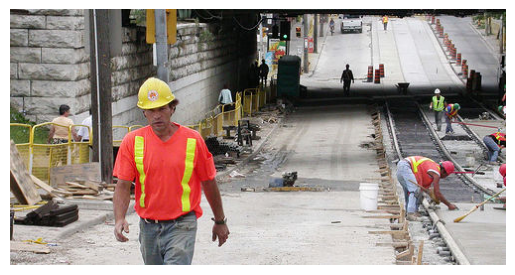

In [78]:
generate_caption("24187497.jpg", model, features, mapping, my_vocab, max_length, device)